In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neural_network import MLPClassifier

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df = pd.read_csv('NFL_pbp_2009-2019.csv', low_memory=False)

threshold = 100000
df['field_goal_result'].fillna('none', inplace=True)
dfV2 = df.loc[:, df.isnull().sum() < threshold]
missing_values = dfV2.isnull().sum()

statistical_cols = ['play_id', 'game_id', 'home_team', 'away_team', 'posteam', 
                    'defteam', 'side_of_field', 'yardline_100', 'half_seconds_remaining', 
                    'game_seconds_remaining', 'game_half', 'drive', 'qtr', 'down', 'goal_to_go', 'time', 
                    'yrdln', 'ydstogo', 'ydsnet', 'desc', 'play_type', 'yards_gained', 'home_timeouts_remaining', 
                    'away_timeouts_remaining', 'total_home_score',  'total_away_score', 'score_differential', 'home_wp', 'away_wp', 'ep']

game_dynamics_cols = [
    'punt_blocked', 'first_down_rush', 'first_down_pass', 'first_down_penalty', 'third_down_converted',
    'third_down_failed', 'fourth_down_converted', 'fourth_down_failed', 'incomplete_pass', 'interception',
    'fumble_forced', 'fumble_not_forced', 'fumble_out_of_bounds', 'solo_tackle', 'safety', 'penalty',
    'tackled_for_loss', 'fumble_lost', 'own_kickoff_recovery', 'own_kickoff_recovery_td', 'qb_hit',
    'rush_attempt', 'pass_attempt', 'sack', 'touchdown', 'pass_touchdown', 'rush_touchdown', 'field_goal_result',
    'return_touchdown', 'extra_point_attempt', 'two_point_attempt', 'field_goal_attempt', 'kickoff_attempt',
    'punt_attempt', 'fumble', 'complete_pass', 'shotgun', 'no_huddle', 'punt_inside_twenty', 'kickoff_inside_twenty']

columns_to_keep = statistical_cols + game_dynamics_cols
dfV3 = dfV2[columns_to_keep]

dfV4 = dfV3.drop(['play_id', 'game_seconds_remaining', 'fumble_forced'], axis=1)
dfV4 = dfV4.dropna(subset=['down', 'defteam', 'posteam'])
dfV4 = dfV4.reset_index(drop=True)

# Indicators for if within last 2 minutes of the half and the whole game
dfV4['close_to_end_of_half'] = (dfV4['half_seconds_remaining'] <= 120).astype(int)
dfV4['close_to_end_of_game'] = ((dfV4['half_seconds_remaining'] <= 120) & (dfV4['game_half'] == 'Half2')).astype(int)

# Indicator for if the touchdown was for the away or home team
dfV4['home_td'] = ((dfV4['touchdown'] == 1) & (dfV4['posteam'] != dfV4['away_team'])).astype(int)
dfV4['away_td'] = ((dfV4['touchdown'] == 1) & (dfV4['posteam'] != dfV4['home_team'])).astype(int)

# Trackers for the difference in both teams' win probability after each play
dfV4['home_wp_change'] = dfV4['home_wp'].diff().fillna(0)
dfV4['away_wp_change'] = dfV4['away_wp'].diff().fillna(0)

# Indicator for turnover
dfV4['turnover'] = (
    (dfV4['safety'] == 1) |
    (dfV4['interception'] == 1) |
    (dfV4['fumble_lost'] == 1) |
    ((dfV4['fourth_down_converted'] == 0) & (dfV4['down'] == 4))
).astype(int)

# Drive time - Added drive ended indicator to help - Manually resets after end of game, half, and change of possession
dfV4['drive_ended'] = (
    (dfV4['posteam'] != dfV4['posteam'].shift(1)) |  
    (dfV4['game_id'] != dfV4['game_id'].shift(1)) |  
    dfV4['desc'].str.contains('END GAME', na=False) |  
    dfV4['desc'].str.contains('END QUARTER', na=False)  
).astype(int)
dfV4['drive'] = (
    (dfV4['posteam'].ne(dfV4['posteam'].shift())) |
    (dfV4['game_id'].ne(dfV4['game_id'].shift()))
).cumsum()
dfV4['drive_time_seconds'] = (
    dfV4.groupby(['game_id', 'drive'])['half_seconds_remaining']
    .transform('first') - dfV4['half_seconds_remaining']
)
dfV4['drive_time_seconds'] = dfV4.apply(
    lambda row: 0 if row['drive_ended'] == 1 else row['drive_time_seconds'], axis=1
)
dfV4['drive_time_seconds'] = dfV4.groupby(['game_id', 'drive'])['drive_time_seconds'].cumsum()

# Indicator for long touchdowns
dfV4['long_td'] = ((dfV4['touchdown'] == 1) & (dfV4['yards_gained'] >= 50)).astype(int)

# Trackers for score differentials and lead changes
dfV4['home_score_differential'] = dfV4['total_home_score'] - dfV4['total_away_score']
dfV4['away_score_differential'] = -dfV4['home_score_differential']
dfV4['lead_change'] = ((dfV4['home_score_differential'].diff() < 0) &
                       (dfV4['home_score_differential'].shift() * dfV4['home_score_differential'] < 0)).astype(int)

# Combining first down indicators
dfV4['first_down'] = ((dfV4['first_down_pass'] == 1) | (dfV4['first_down_rush'] == 1) | (dfV4['first_down_penalty'] == 1)).astype(int)

# Indicators for scoring drives - Removing
dfV4['home_scoring_drive'] = (
    (dfV4['home_td'] == 1) 
).astype(int)
dfV4['away_scoring_drive'] = (
    (dfV4['away_td'] == 1) 
).astype(int)

# Helper for consecutive scoring events - Remove Later!!!!!!!!!!!!!!
dfV4['home_scoring_events'] = (
    (dfV4['posteam'] != dfV4['away_team']) & 
    ((dfV4['home_td'] == 1) | (dfV4['field_goal_result'] == 'made'))
).astype(int)
dfV4['away_scoring_events'] = (
    (dfV4['posteam'] != dfV4['home_team']) & 
    ((dfV4['away_td'] == 1) | (dfV4['field_goal_result'] == 'made'))
).astype(int)

# Consecutive Scoring Events + Helper function 
def calc_consecutive_cumsum_with_game_reset(series, reset_series, game_ids):
    cumsum = 0
    consecutive = []
    prev_game_id = None  
    
    for i in range(len(series)):
        if game_ids[i] != prev_game_id:
            cumsum = 0 
        if reset_series[i] == 1:  
            cumsum = 0
        if series[i] == 1:  
            cumsum += 1
        consecutive.append(cumsum)
        prev_game_id = game_ids[i]  
    return consecutive

dfV4['home_csum_scores'] = calc_consecutive_cumsum_with_game_reset(
    dfV4['home_scoring_events'], dfV4['away_scoring_events'], dfV4['game_id']
)
dfV4['away_csum_scores'] = calc_consecutive_cumsum_with_game_reset(
    dfV4['away_scoring_events'], dfV4['home_scoring_events'], dfV4['game_id']
)

#Consecutive defensive stops
dfV4['home_def_stop'] = (
    (dfV4['posteam'] != dfV4['home_team']) &  ((dfV4['punt_attempt'] == 1) |  (dfV4['turnover'] == 1)) & 
    ~dfV4['field_goal_result'].isin(['made'])  
).astype(int)
dfV4['away_def_stop'] = (
    (dfV4['posteam'] != dfV4['away_team']) & ((dfV4['punt_attempt'] == 1) |  (dfV4['turnover'] == 1)) & 
    ~dfV4['field_goal_result'].isin(['made'])
).astype(int)

def calc_consecutive_defensive_stops_with_game_reset(series, reset_series, game_ids):
    cumsum = 0
    consecutive = []
    prev_game_id = None  
    for i in range(len(series)):
        if game_ids[i] != prev_game_id:
            cumsum = 0
        if reset_series[i] == 1:
            cumsum = 0
        if series[i] == 1:
            cumsum += 1
        consecutive.append(cumsum)
        prev_game_id = game_ids[i]  
    return consecutive

dfV4['home_csum_def_stops'] = calc_consecutive_defensive_stops_with_game_reset(
    dfV4['home_def_stop'], dfV4['away_scoring_events'], dfV4['game_id']
)
dfV4['away_csum_def_stops'] = calc_consecutive_defensive_stops_with_game_reset(
    dfV4['away_def_stop'], dfV4['home_scoring_events'], dfV4['game_id']
)

# Home/Away Drive Numbers
dfV4['away_drive_number'] = (
    dfV4.loc[dfV4['posteam'] != dfV4['home_team']]
    .groupby('game_id')['drive_ended'].cumsum()
)
dfV4['home_drive_number'] = (
    dfV4.loc[dfV4['posteam'] == dfV4['home_team']]
    .groupby('game_id')['drive_ended'].cumsum()
)

# Offense needs to score
dfV4['off_need_score'] = (
    (dfV4['down'].isin([3, 4])) & 
    (abs(dfV4['score_differential']) <= 8) & 
    (dfV4['qtr'] >= 4) &
    (dfV4['first_down'] == 1)
).astype(int)

# Defense Needs a Stop
dfV4['def_need_stop'] = (
    (dfV4['down'].isin([3, 4])) & 
    (abs(dfV4['score_differential']) <= 8) & 
    (dfV4['qtr'] >= 4) &
    (dfV4['turnover'] == 1)
).astype(int)

# Drought Ending score
dfV4['drought_end_play'] = (
    ((dfV4['away_csum_scores'].shift(1) >= 2) & (dfV4['away_csum_scores'] == 0) & (dfV4['home_scoring_events'] == 1)) |
    ((dfV4['home_csum_scores'].shift(1) >= 2) & (dfV4['home_csum_scores'] == 0) & (dfV4['away_scoring_events'] == 1))
).astype(int)

# Defensive touchdown
dfV4['def_td'] = (
    ((dfV4['fumble'] == 1) & (dfV4['return_touchdown'] == 1)) |
    ((dfV4['interception'] == 1) & (dfV4['return_touchdown'] == 1))
).astype(int)

# Defensive touchdown
dfV4['off_td'] = (
    (dfV4['pass_touchdown'] == 1) | (dfV4['rush_touchdown'] == 1)
).astype(int)

# Special Teams touchdown
dfV4['st_return_td'] = (
    ((dfV4['kickoff_attempt'] == 1) & (dfV4['return_touchdown'] == 1)) | 
    ((dfV4['punt_attempt'] == 1) & (dfV4['return_touchdown'] == 1))  
).astype(int)

# Big special teams play...punt blocked, field goal blocked, return_touchdown, kick recovery, pin team near endzone
dfV4['big_st_play'] = (
    (dfV4['punt_blocked'] == 1) | 
    (dfV4['field_goal_result'] == 'blocked') | 
    (dfV4['own_kickoff_recovery'] == 1) | 
    (dfV4['st_return_td'] == 1) | 
    (dfV4['kickoff_inside_twenty'] == 1) | 
    (dfV4['punt_inside_twenty'] == 1)
).astype(int)

# Scoring type differentiatior, touchdowns should hold more weight than a field goal, other types may hold more weight also
dfV4['scoring_type'] = np.select(
    [
        dfV4['field_goal_result'] == 'made',
        dfV4['off_td'] == 1,
        dfV4['def_td'] == 1,
        dfV4['st_return_td'] == 1,
    ],
    ['fg', 'off_td', 'def_td', 'st_td'],
    default='none'
)

# Indicator for big offensive play
dfV4['big_offensive_play'] = (
        (dfV4['yards_gained'] >= 40) |
        (dfV4['long_td'] == 1) |
        ((dfV4['off_need_score'] == 1) & (dfV4['off_td'] == 1))
).astype(int)

# Indicator for big defensive play
dfV4['big_defensive_play'] = (
    (dfV4['sack'] == 1) |
    (dfV4['tackled_for_loss'] == 1) |
    ((dfV4['def_need_stop'] == 1) & ((dfV4['def_td'] == 'def_td')) | dfV4['turnover'] == 1) |
    (dfV4['scoring_type'] == 'def_td')
).astype(int)

#Quick Score and Quick Stop #### Needs fixing, only want 1 on last play of drive when they score or get stop, right now 1 for whole drive
dfV4['total_drive_time'] = dfV4.groupby('drive')['drive_time_seconds'].transform('last') 
dfV4['cumulative_drive_time'] = dfV4.groupby(['game_id', 'drive'])['drive_time_seconds'].cumsum()
dfV4['long_drive_triggered'] = (
    dfV4.groupby(['game_id', 'drive'])['cumulative_drive_time']
    .transform(lambda x: (x > 360).idxmax() == x.index)  # Flags the first row that exceeds 360s
).astype(int)

dfV4['quick_score'] = (
    (dfV4['drive_time_seconds'] < 180) &
    ((dfV4['touchdown'] == 1) | (dfV4['field_goal_result'] == 'made')) &
    (dfV4.groupby('drive')['drive_time_seconds'].transform('last') == dfV4['drive_time_seconds'])
).astype(int)
dfV4['quick_stop'] = (
    (dfV4['total_drive_time'] < 180) & 
    (dfV4['scoring_type'] == 'none') &
    (dfV4.groupby('drive')['drive_time_seconds'].transform('last') == dfV4['drive_time_seconds'])
).astype(int)

# Consecutive first downs
dfV4['home_csum_first_downs'] = 0
dfV4['away_csum_first_downs'] = 0
dfV4['home_csum_first_downs'] = (
    dfV4.groupby(['home_team', 'away_team', 'home_drive_number'])['first_down']
    .cumsum()
    .where(dfV4['posteam'] != 'away_team', 0)
)
dfV4['away_csum_first_downs'] = (
    dfV4.groupby(['home_team', 'away_team', 'away_drive_number'])['first_down']
    .cumsum()
    .where(dfV4['posteam'] != 'home_team', 0)
)


columns_to_remove = [
    'ep', 'punt_blocked', 'first_down_rush', 'first_down_pass', 
    'third_down_converted', 'third_down_failed', 'fourth_down_converted', 
    'fourth_down_failed', 'incomplete_pass', 'interception', 'fumble_not_forced', 
    'fumble_out_of_bounds', 'solo_tackle', 'safety', 'penalty', 'tackled_for_loss', 
    'fumble_lost', 'own_kickoff_recovery', 'own_kickoff_recovery_td', 'qb_hit', 
    'rush_attempt', 'pass_attempt', 'sack', 'extra_point_attempt', 'two_point_attempt', 
    'field_goal_attempt', 'kickoff_attempt', 'punt_attempt', 'fumble', 'pass_touchdown', 'rush_touchdown'
    'complete_pass', 'shotgun', 'home_scoring_drive', 'away_scoring_drive','home_scoring_events','away_scoring_events',
    'rush_touchdown', 'field_goal_result', 'return_touchdown', 'complete_pass', 'no_huddle', 'punt_inside_twenty', 'kickoff_inside_twenty',
    'time', 'yrdln', 'ydstogo', 'ydsnet', 'desc', 'side_of_field', 'yardline_100', 'desc', 'drive', 'game_half', 'drive_ended', 'drive_time_seconds',
    'touchdown', 'score_differential', 'total_drive_time'
]

dfV5 = dfV4.drop(columns=columns_to_remove, errors='ignore')

dynamics = [
    ('big_offensive_play', dfV5['big_offensive_play'] == 1),
    ('big_defensive_play', dfV5['big_defensive_play'] == 1),
    ('off_td', dfV5['off_td'] == 1),
    ('def_td', dfV5['def_td'] == 1),
    ('big_st_play', dfV5['big_st_play'] == 1),
    ('st_return_td', dfV5['st_return_td'] == 1),
    ('off_need_score', dfV5['off_need_score'] == 1),
    ('def_need_stop', dfV5['def_need_stop'] == 1),
    ('drought_end_play', dfV5['drought_end_play'] == 1),
    ('home_csum_scores', dfV5['home_csum_scores'] >= 2),
    ('away_csum_scores', dfV5['away_csum_scores'] >= 2),
    ('home_csum_def_stops', dfV5['home_csum_def_stops'] >= 2),
    ('away_csum_def_stops', dfV5['away_csum_def_stops'] >= 2),
    ('home_csum_first_downs', dfV5['home_csum_first_downs'] >= 2),
    ('away_csum_first_downs', dfV5['away_csum_first_downs'] >= 2),
    ('long_td', dfV5['long_td'] == 1),
    ('quick_score', dfV5['quick_score'] == 1),
    ('quick_stop', dfV5['quick_stop'] == 1),
    ('home_score_differential', dfV5['home_score_differential'] == 1),
    ('away_score_differential', dfV5['away_score_differential'] == 1),
]


def_wp_change = {
    "big_defensive_play": 0.029471,
    "def_td": 0.016322,
    "big_st_play": 0.034637,
    "st_return_td": 0.040082,
    "def_need_stop": 0.042132,
    "quick_stop": 0.029971
}

off_wp_change = {
    "big_offensive_play": 0.038602,
    "off_td": 0.028432,
    "off_need_score":  0.035536, 
    "drought_end_play": 0.028891,
    "long_td": 0.033325,
    "quick_score": 0.026664
}

streaks_multipliers = {
    "home_csum_scores": 1.118986,
    "away_csum_scores": 1.118986,
    "home_csum_first_downs": 1.1112094,
    "away_csum_first_downs": 1.1112094,
    "home_csum_def_stops": 1.111932,
    "away_csum_def_stops": 1.111932,
}

score_game_multipliers = {
    "tied_or_1_score": 1.06634844,
    "2_score": 1.035777727,
    "3_or_more_score": 1.0274060
}

qtr_multipliers = {
    "first_and_fourth": 1.5522285,
    "second_and_third": 1.3201836
}

home_away_multipliers = {
    "home": 1.07949869,  
    "away": 1.06027507 
}

boost_case_multipliers = {
    "home_and_4th": 1.122276683,  
    "away_and_1st": 1.16675933,  
    "none": 1.0           
}

decay_multipliers = {
    "opponent_scores": 0.68004571,
    "turnover": 0.21742678,
    "opponent_ends_drought": 0.18212307,
    "long_possession":  0.1534018395,
    "none": 0.0  
}



def calculate_multipliers(row, index, category, is_offensive):
    if abs(row['home_score_differential']) <= 8:
        S = score_game_multipliers["tied_or_1_score"]
    elif 9 <= abs(row['home_score_differential']) <= 16:
        S = score_game_multipliers["2_score"]
    else:
        S = score_game_multipliers["3_or_more_score"]

    team = row['posteam'] if is_offensive else row['defteam']
    HA = home_away_multipliers.get(team, 1.0)

    if row['qtr'] == 1 or row['qtr'] == 4:
        Q = qtr_multipliers["first_and_fourth"]
    else:
        Q = qtr_multipliers["second_and_third"]

    if is_offensive:
        if row['posteam'] == 'home' and row['qtr'] == 4:
            B = boost_case_multipliers["home_and_4th"]
        elif row['posteam'] == 'away' and row['qtr'] == 1:
            B = boost_case_multipliers["away_and_1st"]
        else:
            B = 1.0
    else:
        if team == 'home' and row['qtr'] == 4:
            B = boost_case_multipliers["home_and_4th"]
        elif team == 'away' and row['qtr'] == 1:
            B = boost_case_multipliers["away_and_1st"]
        else:
            B = 1.0

    CS = 1.0
   
    if is_offensive:
        if row['posteam'] == row['home_team']:
            if row['home_csum_scores'] >= 2:
                if row['home_csum_scores'] > dfV5.at[index - 1, 'home_csum_scores']: 
                    CS = streaks_multipliers['home_csum_scores']
            elif row['home_csum_first_downs'] >= 4:
                if row['home_csum_first_downs'] > dfV5.at[index - 1, 'home_csum_first_downs']: 
                    CS = streaks_multipliers['home_csum_first_downs']
            else:
                CS = 1.0
        else:
            if row['away_csum_scores'] >= 2:
                if row['away_csum_scores'] > dfV5.at[index - 1, 'away_csum_scores']: 
                    CS = streaks_multipliers['away_csum_scores']
            elif row['away_csum_first_downs'] >= 4:
                if row['away_csum_first_downs'] >  dfV5.at[index - 1, 'away_csum_first_downs']: 
                    CS = streaks_multipliers['away_csum_first_downs']
            else:
                CS = 1.0
    else:
        if row['defteam'] == row['home_team']:
            if row['home_csum_def_stops'] >= 2:
                if row['home_csum_def_stops'] > dfV5.at[index - 1, 'home_csum_def_stops']: 
                    CS = streaks_multipliers['home_csum_def_stops']
            else:
                CS = 1.0
        else:
            if row['away_csum_def_stops'] >= 2:
                if row['away_csum_def_stops'] > dfV5.at[index - 1, 'away_csum_def_stops']:
                    CS = streaks_multipliers['away_csum_def_stops']
            else:
                CS = 1.0

    return S, HA, B, CS, Q



def calculate_momentum_gain(wp_change_value, S, HA, CS, B, Q):
    return wp_change_value * (S * HA * CS * B * Q) * 1000



def calculate_decay(row, category, momentum_gain):
    if category in ['off_td', 'long_td', 'def_td', 'st_return_td']:
        D = decay_multipliers['opponent_scores']
    elif row['turnover'] == 1:
        D = decay_multipliers['turnover']
    elif row['drought_end_play'] == 1:
        D = decay_multipliers["opponent_ends_drought"]
    elif row['long_drive_triggered'] == 1:  
        D = decay_multipliers['long_possession']
    else:
        D = decay_multipliers['none']

    return momentum_gain * D



def update_momentum_scores(dfV5):
    dfV5['Home_Momentum_Score'] = 500
    dfV5['Away_Momentum_Score'] = 500

    dfV5['game_id_diff'] = dfV5['game_id'] != dfV5['game_id'].shift(1)

    for index, row in dfV5.iterrows():
        if index == 0:  
            continue

        if row['game_id_diff']:
            dfV5.at[index, 'Home_Momentum_Score'] = 500
            dfV5.at[index, 'Away_Momentum_Score'] = 500
            continue

        home_momentum_gain = 0
        away_momentum_gain = 0

        for category, wp_change_value in off_wp_change.items():
            if row[category] == 1:
                S, HA, B, CS, Q = calculate_multipliers(row, index, category, True)
                momentum_gain = calculate_momentum_gain(wp_change_value, S, HA, CS, B, Q)
                momentum_loss = calculate_decay(row, category, momentum_gain)

                if row['posteam'] == row['home_team']:
                    home_momentum_gain += momentum_gain
                    away_momentum_gain -= momentum_loss
                else:
                    away_momentum_gain += momentum_gain
                    home_momentum_gain -= momentum_loss

        for category, wp_change_value in def_wp_change.items():
            if row[category] == 1:
                S, HA, B, CS, Q = calculate_multipliers(row, index, category, False)
                momentum_gain = calculate_momentum_gain(wp_change_value, S, HA, CS, B, Q)
                momentum_loss = calculate_decay(row, category, momentum_gain)

                if row['defteam'] == row['home_team']:
                    home_momentum_gain += momentum_gain
                    away_momentum_gain -= momentum_loss
                else:
                    away_momentum_gain += momentum_gain
                    home_momentum_gain -= momentum_loss

        dfV5.at[index, 'Home_Momentum_Score'] = dfV5.at[index - 1, 'Home_Momentum_Score'] + home_momentum_gain
        dfV5.at[index, 'Away_Momentum_Score'] = dfV5.at[index - 1, 'Away_Momentum_Score'] + away_momentum_gain

update_momentum_scores(dfV5)

dfV5['Game_Momentum_Diff'] = 0

historical_max_diff_mean = dfV5.groupby('game_id')['Game_Momentum_Diff'].max().mean()
historical_max_diff_std = dfV5.groupby('game_id')['Game_Momentum_Diff'].max().std()

base_threshold = historical_max_diff_mean + 0.8 * historical_max_diff_std #.7

dfV5['Game_Momentum_Diff'] = abs(dfV5['Home_Momentum_Score'] - dfV5['Away_Momentum_Score'])
dfV5['Dynamic_Threshold'] = None
dfV5['Momentum_Holding_Team'] = None

def detect_momentum_shifts(game_data):
    momentum_holding_team = None
    last_shift_home_momentum = game_data.iloc[0]['Home_Momentum_Score']
    last_shift_away_momentum = game_data.iloc[0]['Away_Momentum_Score']
    max_momentum_diff_so_far = 0

    for i in range(1, len(game_data)): 
        if i < 10:  # Ignore shifts for the first 10 plays
            continue
        home_momentum_diff = game_data.iloc[i]['Home_Momentum_Score'] - last_shift_home_momentum
        away_momentum_diff = game_data.iloc[i]['Away_Momentum_Score'] - last_shift_away_momentum        

        current_momentum_diff = abs(game_data.iloc[i]['Home_Momentum_Score'] - game_data.iloc[i]['Away_Momentum_Score'])
        max_momentum_diff_so_far = max(max_momentum_diff_so_far, current_momentum_diff)
        game_threshold = max(base_threshold, 0.8 * max_momentum_diff_so_far) #.7
        game_data.iloc[i, game_data.columns.get_loc('Dynamic_Threshold')] = game_threshold

        home_momentum_shift = False
        away_momentum_shift = False

        if home_momentum_diff >= game_threshold and away_momentum_diff < game_threshold * 0.8: #.5
            home_momentum_shift = True
        elif away_momentum_diff >= game_threshold and home_momentum_diff < game_threshold * 0.8: #.5
            away_momentum_shift = True

        if home_momentum_shift:
            momentum_holding_team = "Home"
            last_shift_home_momentum = game_data.iloc[i]['Home_Momentum_Score']
            last_shift_away_momentum = game_data.iloc[i]['Away_Momentum_Score']
        elif away_momentum_shift:
            momentum_holding_team = "Away"
            last_shift_home_momentum = game_data.iloc[i]['Home_Momentum_Score']
            last_shift_away_momentum = game_data.iloc[i]['Away_Momentum_Score']

        game_data.iloc[i, game_data.columns.get_loc('Momentum_Holding_Team')] = momentum_holding_team

    return game_data

dfV5 = dfV5.groupby('game_id', group_keys=False).apply(detect_momentum_shifts)

dfV5['Momentum_Shift_Occurred'] = dfV5.groupby('game_id')['Momentum_Holding_Team'].transform(
    lambda x: x.ne(x.shift()) & x.notna()
)

columns_to_fill = ['home_drive_number', 'away_drive_number', 'home_csum_first_downs', 
                    'away_csum_first_downs', 'Dynamic_Threshold', 'yards_gained']
dfV5[columns_to_fill] = dfV5[columns_to_fill].fillna(0)

features = dfV5.drop(['Momentum_Shift_Occurred'], axis=1)  
numeric_df = dfV5.select_dtypes(include=[np.number])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df)

df = dfV5.copy()

excluded_cols = ['game_id', 'Momentum_Shift_Occurred', 'Momentum_Holding_Team']
target_col = 'Momentum_Shift_Occurred'
feature_df = df.drop(columns=excluded_cols, errors='ignore')

numeric_cols = feature_df.select_dtypes(include=['number']).columns
categorical_cols = feature_df.select_dtypes(exclude=['number']).columns
if len(categorical_cols) > 0:
    feature_df = pd.get_dummies(feature_df, columns=categorical_cols, drop_first=True)

unique_games = df['game_id'].unique()
unique_games_sorted = sorted(unique_games)
train_size = int(0.8 * len(unique_games_sorted))
train_games = unique_games_sorted[:train_size]
test_games = unique_games_sorted[train_size:]

feature_df['game_id'] = df['game_id']
train_features = feature_df[feature_df['game_id'].isin(train_games)].drop(columns='game_id')
test_features = feature_df[feature_df['game_id'].isin(test_games)].drop(columns='game_id')
X_train = train_features.values
X_test = test_features.values
y_train = df.loc[df['game_id'].isin(train_games), target_col].astype(int).values
y_test = df.loc[df['game_id'].isin(test_games), target_col].astype(int).values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

C:\Users\seanz\AppData\Local\Temp\ipykernel_30132\4107407487.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['field_goal_result'].fillna('none', inplace=True)
C:\Users\seanz\AppData\Local\Temp\ipykernel_30132\4107407487.py:521: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '548.7808836884615' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfV5.at[index, 'Home_Momentum_Score'] = dfV5.at[index - 1, 

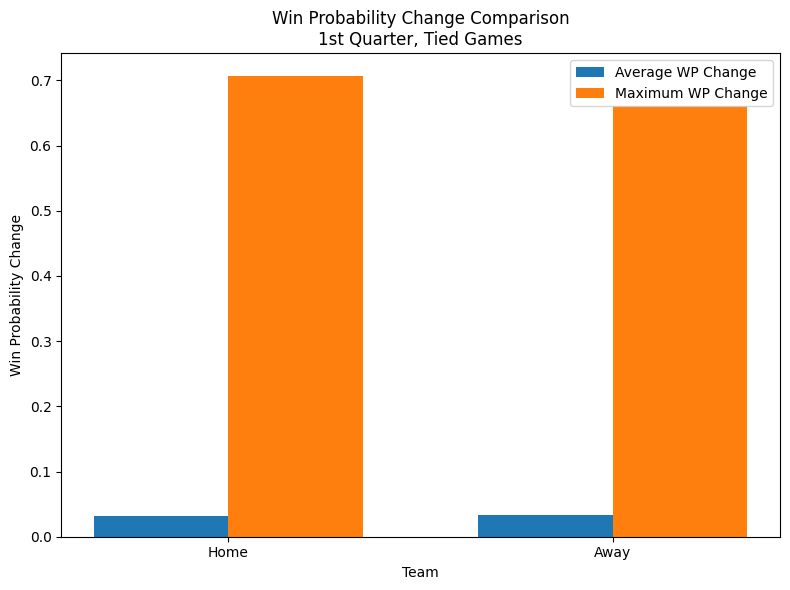

   Team  Average WP Change  Maximum WP Change
0  Home           0.031078           0.706451
1  Away           0.032671           0.661103


In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter for tied games in the first quarter
df_first_qtr_tied = dfV5[
    (dfV5['qtr'] == 1) &
    ((dfV5['off_td'] == 1))
]

# Home team scoring
home_scoring_df = df_first_qtr_tied[df_first_qtr_tied['posteam'] == df_first_qtr_tied['home_team']]
home_wp_changes = pd.concat([home_scoring_df['home_wp_change'], home_scoring_df['away_wp_change']])
home_wp_changes = home_wp_changes[home_wp_changes >= 0]  # Consider only positive changes
home_avg_wp_change = home_wp_changes.mean()
home_max_wp_change = home_wp_changes.max()

# Away team scoring
away_scoring_df = df_first_qtr_tied[df_first_qtr_tied['posteam'] == df_first_qtr_tied['away_team']]
away_wp_changes = pd.concat([away_scoring_df['home_wp_change'], away_scoring_df['away_wp_change']])
away_wp_changes = away_wp_changes[away_wp_changes >= 0]
away_avg_wp_change = away_wp_changes.mean()
away_max_wp_change = away_wp_changes.max()

# Create DataFrame for visualization
wp_data = pd.DataFrame({
    'Team': ['Home', 'Away'],
    'Average WP Change': [home_avg_wp_change, away_avg_wp_change],
    'Maximum WP Change': [home_max_wp_change, away_max_wp_change]
})

# Plot
plt.figure(figsize=(8, 6))
bar_width = 0.35
index = wp_data.index

plt.bar(index, wp_data['Average WP Change'], bar_width, label='Average WP Change')
plt.bar(index + bar_width, wp_data['Maximum WP Change'], bar_width, label='Maximum WP Change')

plt.xlabel('Team')
plt.ylabel('Win Probability Change')
plt.title('Win Probability Change Comparison\n1st Quarter, Tied Games')
plt.xticks(index + bar_width / 2, wp_data['Team'])
plt.legend()
plt.tight_layout()
plt.show()

# Print the data for reference
print(wp_data)

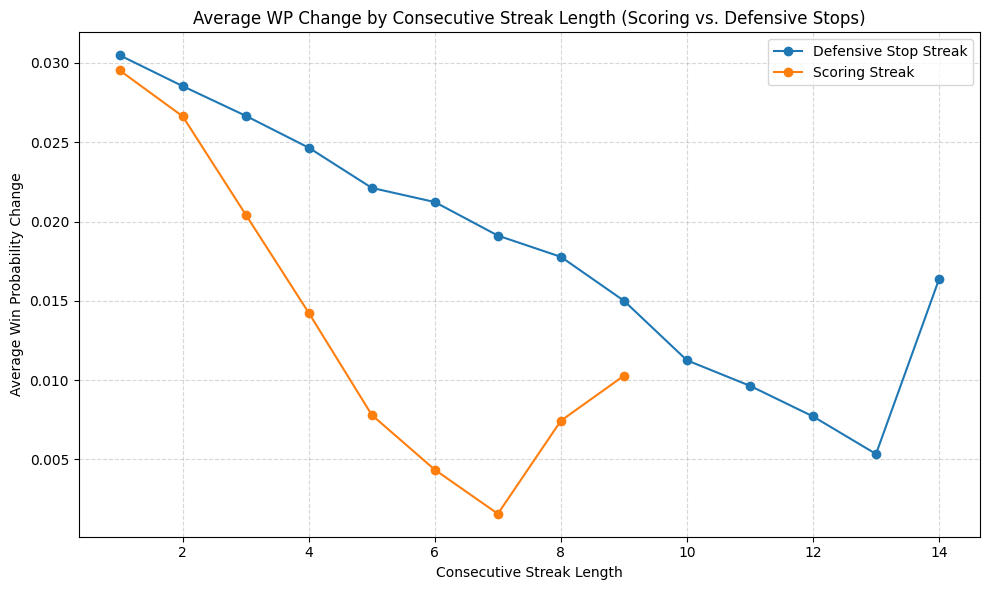

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Combine home and away cumulative scores/stops into one column
dfV5['csum_scores'] = dfV5[['home_csum_scores', 'away_csum_scores']].max(axis=1)
dfV5['csum_def_stops'] = dfV5[['home_csum_def_stops', 'away_csum_def_stops']].max(axis=1)

# Take the maximum absolute WP change for each row (or average if you prefer)
dfV5['wp_change'] = dfV5[['home_wp_change', 'away_wp_change']].abs().max(axis=1)

# Prepare an empty DataFrame to collect results
all_streaks_list = []

# Analyze scoring streaks
scoring_streaks = dfV5[dfV5['csum_scores'] >= 1].copy()
scoring_grouped = (
    scoring_streaks.groupby('csum_scores')['wp_change']
    .mean()
    .reset_index()
    .rename(columns={'csum_scores': 'streak_length', 'wp_change': 'avg_wp_change'})
)
scoring_grouped['streak_type'] = 'Scoring'

all_streaks_list.append(scoring_grouped)

# Analyze defensive stops streaks
def_stops_streaks = dfV5[dfV5['csum_def_stops'] >= 1].copy()
def_stops_grouped = (
    def_stops_streaks.groupby('csum_def_stops')['wp_change']
    .mean()
    .reset_index()
    .rename(columns={'csum_def_stops': 'streak_length', 'wp_change': 'avg_wp_change'})
)
def_stops_grouped['streak_type'] = 'Defensive Stop'

all_streaks_list.append(def_stops_grouped)

# Combine into one DataFrame
all_streaks_df = pd.concat(all_streaks_list, ignore_index=True)

# Plot
plt.figure(figsize=(10, 6))
for streak_type, df_streak in all_streaks_df.groupby('streak_type'):
    plt.plot(
        df_streak['streak_length'],
        df_streak['avg_wp_change'],
        marker='o',
        label=f'{streak_type} Streak'
    )

plt.xlabel('Consecutive Streak Length')
plt.ylabel('Average Win Probability Change')
plt.title('Average WP Change by Consecutive Streak Length (Scoring vs. Defensive Stops)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

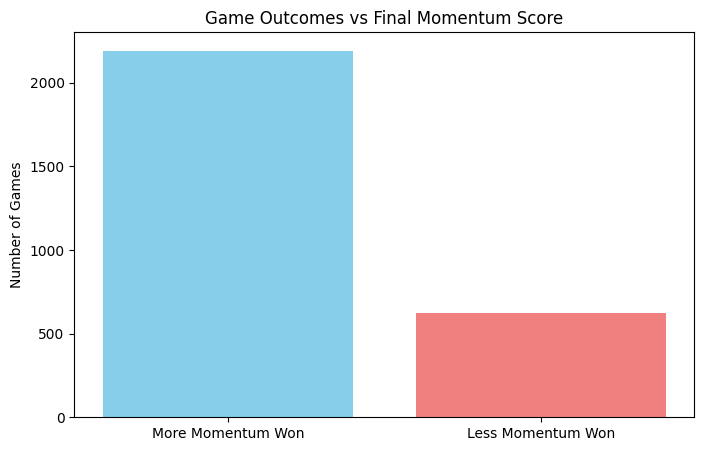

           game_id winner momentum_winner  momentum_match
155     2019090500   away            home           False
314     2019090800   away            away            True
467     2019090806   home            home            True
619     2019090805   away            away            True
758     2019090804   home            home            True
895     2019090803   away            away            True
1026    2019090802   away            away            True
1174    2019090801   away            away            True
1310    2019090807   home            away           False
1457    2019090808   home            away           False
1604    2019090811   away            away            True
1750    2019090810   home            home            True
1948    2019090809    tie            home           False
2100    2019090812   home            home            True
2244    2019090900   home            home            True
2377    2019090901   home            home            True
2539    201909

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Get final momentum scores for each game
final_momentum = dfV5.groupby('game_id').tail(1)[
    ['game_id', 'Home_Momentum_Score', 'Away_Momentum_Score', 'total_home_score', 'total_away_score']
].copy()

# 2️⃣ Determine the actual winner of each game
final_momentum['winner'] = final_momentum.apply(
    lambda row: 'home' if row['total_home_score'] > row['total_away_score'] else (
        'away' if row['total_away_score'] > row['total_home_score'] else 'tie'
    ),
    axis=1
)

# 3️⃣ Determine who had more final momentum
final_momentum['momentum_winner'] = final_momentum.apply(
    lambda row: 'home' if row['Home_Momentum_Score'] > row['Away_Momentum_Score'] else (
        'away' if row['Away_Momentum_Score'] > row['Home_Momentum_Score'] else 'tie'
    ),
    axis=1
)

# 4️⃣ Compare momentum winner to actual winner
final_momentum['momentum_match'] = final_momentum['momentum_winner'] == final_momentum['winner']

# 5️⃣ Count and visualize
momentum_wins = final_momentum['momentum_match'].sum()
momentum_losses = len(final_momentum) - momentum_wins

# Plot the bar chart
labels = ['More Momentum Won', 'Less Momentum Won']
counts = [momentum_wins, momentum_losses]
colors = ['skyblue', 'lightcoral']

plt.figure(figsize=(8, 5))
plt.bar(labels, counts, color=colors)
plt.ylabel('Number of Games')
plt.title('Game Outcomes vs Final Momentum Score')
plt.show()

# Optional: Display the final data
print(final_momentum[['game_id', 'winner', 'momentum_winner', 'momentum_match']])

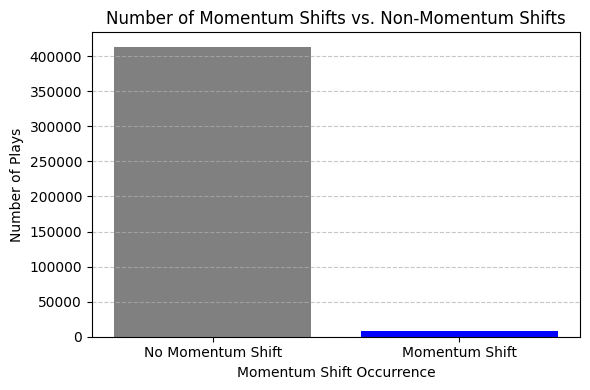

In [26]:
momentum_counts = dfV5['Momentum_Shift_Occurred'].value_counts()

# Create a bar plot
plt.figure(figsize=(6, 4))
plt.bar(['No Momentum Shift', 'Momentum Shift'], momentum_counts, color=['gray', 'blue'])
plt.xlabel('Momentum Shift Occurrence')
plt.ylabel('Number of Plays')
plt.title('Number of Momentum Shifts vs. Non-Momentum Shifts')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [29]:
# Initialize counters
success_reasons = {
    'score': 0,
    'stop': 0,
    'first_downs': 0
}
failure_reasons = {
    'opponent_success_event': 0,
    'no_event_found': 0
}

successful_shifts = 0
total_shifts = 0

momentum_shift_indexes = np.where(dfV5['Momentum_Shift_Occurred'] == True)[0]

for idx in momentum_shift_indexes:
    game_id = dfV5.loc[idx, 'game_id']

    # Determine which team had the bigger momentum gain at this shift
    home_diff = dfV5.loc[idx, 'Home_Momentum_Score'] - dfV5.loc[idx - 1, 'Home_Momentum_Score']
    away_diff = dfV5.loc[idx, 'Away_Momentum_Score'] - dfV5.loc[idx - 1, 'Away_Momentum_Score']

    if home_diff > away_diff:
        momentum_team = dfV5.loc[idx, 'home_team']
    else:
        momentum_team = dfV5.loc[idx, 'away_team']

    consecutive_first_downs = 0
    success = False
    failed = False
    i = idx + 1

    # Initialize first down counters *AFTER* the momentum shift
    consecutive_first_downs = 0

    while i < len(dfV5) and dfV5.loc[i, 'game_id'] == game_id:
        row = dfV5.loc[i]
        
        offense = row['posteam']
        defense = row['defteam']

        # Check if the momentum team is on offense
        if offense == momentum_team:
            if row.get('first_down', 0) == 1:
                consecutive_first_downs += 1
            else:
                consecutive_first_downs = 0  # Reset if no first down

            # Check for scoring events
            if row.get('off_td', 0) == 1 or row.get('scoring_type', '') == 'fg':
                success_reasons['score'] += 1
                success = True
                break

            # Check for 5 *consecutive* first downs AFTER the shift
            if consecutive_first_downs >= 5:
                success_reasons['first_downs'] += 1
                success = True
                break

        # Check if the momentum team is on defense
        elif defense == momentum_team:
            if row.get('turnover', 0) == 1 or row.get('quick_stop', 0) == 1 or row.get('def_td', 0) == 1:
                success_reasons['stop'] += 1
                success = True
                break

        # Opponent success event ends window
        if offense != momentum_team:
            if (
                row.get('off_td', 0) == 1 or
                row.get('scoring_type', '') == 'fg' or
                row.get('quick_score', 0) == 1 or
                (offense == row['home_team'] and row.get('home_csum_first_downs', 0) >= 5) or
                (offense == row['away_team'] and row.get('away_csum_first_downs', 0) >= 5)
            ):
                failure_reasons['opponent_success_event'] += 1
                failed = True
                break

        i += 1

    if success:
        successful_shifts += 1
    elif failed:
        pass  # Already counted
    else:
        failure_reasons['no_event_found'] += 1

    total_shifts += 1

print(total_shifts == successful_shifts + failure_reasons['opponent_success_event'] + failure_reasons['no_event_found'])

print("\n=== AD HOC VALIDATION RESULTS (Actual Momentum Shifts) ===")
print(f"Total Momentum Shifts: {total_shifts}")
print(f"Successful Shifts: {successful_shifts}")
print(f"Success Rate: {successful_shifts / total_shifts:.2%}\n")

print("== Reasons for Success ==")
for reason, count in success_reasons.items():
    print(f"{reason}: {count}")

print("\n== Reasons for Failure ==")
for reason, count in failure_reasons.items():
    print(f"{reason}: {count}")

True

=== AD HOC VALIDATION RESULTS (Actual Momentum Shifts) ===
Total Momentum Shifts: 8701
Successful Shifts: 5569
Success Rate: 64.00%

== Reasons for Success ==
score: 2158
stop: 3409
first_downs: 2

== Reasons for Failure ==
opponent_success_event: 2919
no_event_found: 213


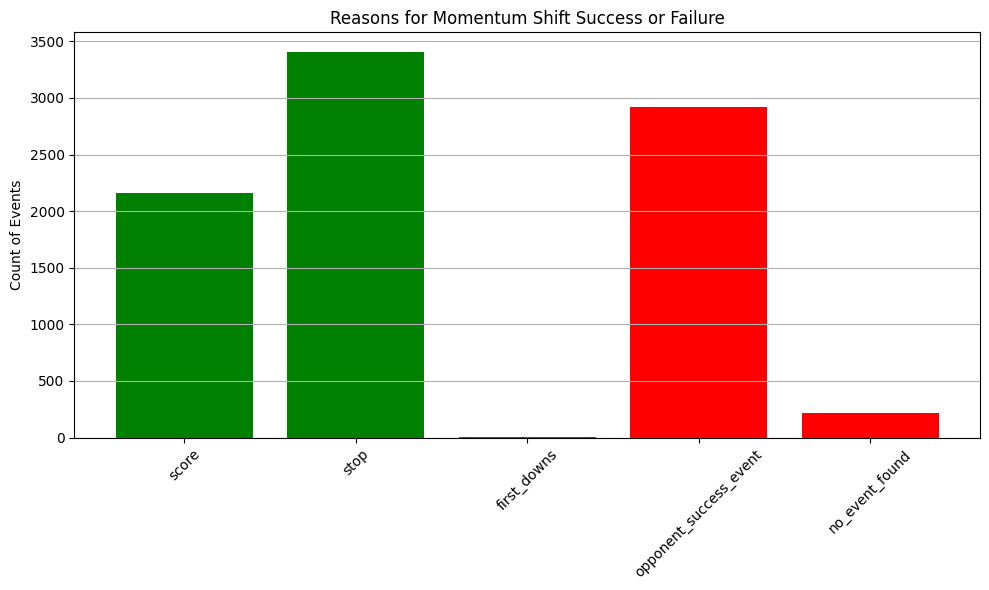

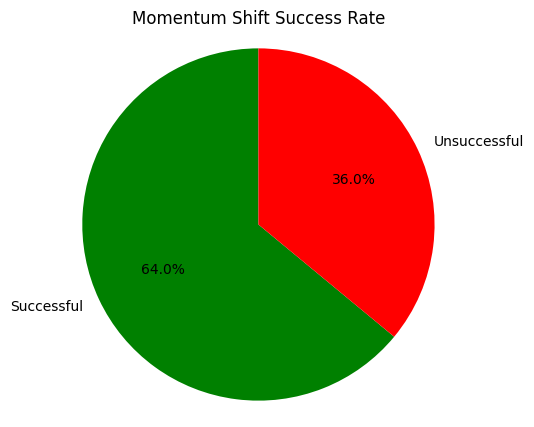

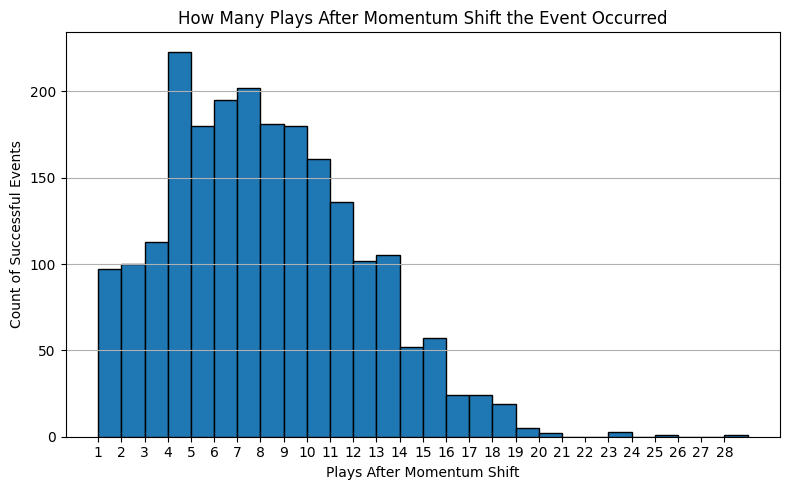

In [30]:
import matplotlib.pyplot as plt

# Updated counts from actual results
success_reasons = {'score': 2158, 'stop': 3409, 'first_downs': 2}
fail_reasons = {'opponent_success_event': 2919, 'no_event_found': 213}

# Combine for display
all_reasons = {**success_reasons, **fail_reasons}
colors = ['green' if k in success_reasons else 'red' for k in all_reasons.keys()]

# 1️⃣ Bar chart of success and failure reasons
plt.figure(figsize=(10, 6))
plt.bar(all_reasons.keys(), all_reasons.values(), color=colors)
plt.title("Reasons for Momentum Shift Success or Failure")
plt.ylabel("Count of Events")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# 2️⃣ Pie chart of overall success vs failure
labels = ['Successful', 'Unsuccessful']
sizes = [5569, 8701 - 5569]
colors = ['green', 'red']

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title("Momentum Shift Success Rate")
plt.axis('equal')
plt.show()

# 3️⃣ How many plays after shift until a successful event
event_offsets = []

momentum_shift_indexes = np.where(dfV5['Momentum_Shift_Occurred'] == True)[0]

for idx in momentum_shift_indexes:
    home_diff = dfV5.loc[idx, 'Home_Momentum_Score'] - dfV5.loc[idx - 1, 'Home_Momentum_Score']
    away_diff = dfV5.loc[idx, 'Away_Momentum_Score'] - dfV5.loc[idx - 1, 'Away_Momentum_Score']
    momentum_team = dfV5.loc[idx, 'home_team'] if home_diff > away_diff else dfV5.loc[idx, 'away_team']
    game_id = dfV5.loc[idx, 'game_id']
    i = idx + 1

    consecutive_first_downs = 0

    while i < len(dfV5) and dfV5.loc[i, 'game_id'] == game_id:
        row = dfV5.loc[i]
        
        # Check for successful events for the momentum team
        if row['posteam'] == momentum_team:
            if row.get('first_down', 0) == 1:
                consecutive_first_downs += 1
            else:
                consecutive_first_downs = 0

            if (
                row.get('off_td', 0) == 1 or
                row.get('scoring_type', '') == 'fg' or
                consecutive_first_downs >= 5
            ):
                event_offsets.append(i - idx)
                break
        else:
            # Check for opponent success to end window
            if (
                row.get('off_td', 0) == 1 or
                row.get('scoring_type', '') == 'fg' or
                row.get('turnover', 0) == 1 or
                row.get('quick_stop', 0) == 1 or
                row.get('def_td', 0) == 1
            ):
                break

        i += 1

# 4️⃣ Histogram of how many plays after shift the success occurred
if event_offsets:
    plt.figure(figsize=(8, 5))
    plt.hist(event_offsets, bins=range(1, max(event_offsets)+2), edgecolor='black')
    plt.title("How Many Plays After Momentum Shift the Event Occurred")
    plt.xlabel("Plays After Momentum Shift")
    plt.ylabel("Count of Successful Events")
    plt.xticks(range(1, max(event_offsets)+1))
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
else:
    print("No successful events found for histogram.")

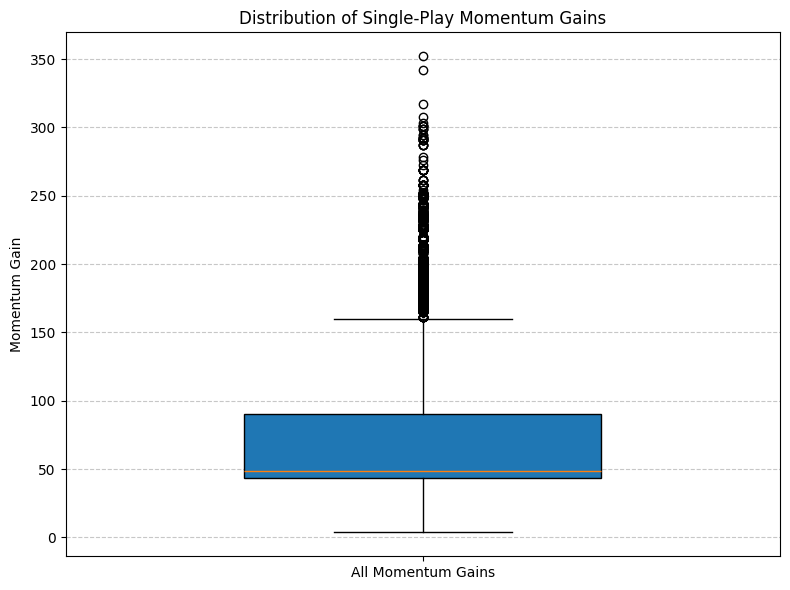

In [4]:
import matplotlib.pyplot as plt

# Calculate single-play momentum changes
dfV5['Home_Momentum_Change'] = dfV5['Home_Momentum_Score'].diff().fillna(0)
dfV5['Away_Momentum_Change'] = dfV5['Away_Momentum_Score'].diff().fillna(0)

# Filter only positive (gains) momentum changes
momentum_gains = pd.concat([
    dfV5[dfV5['Home_Momentum_Change'] > 0]['Home_Momentum_Change'],
    dfV5[dfV5['Away_Momentum_Change'] > 0]['Away_Momentum_Change']
])

# Create boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(momentum_gains, vert=True, patch_artist=True, showfliers=True, widths=0.5)
plt.title('Distribution of Single-Play Momentum Gains')
plt.ylabel('Momentum Gain')
plt.xticks([1], ['All Momentum Gains'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

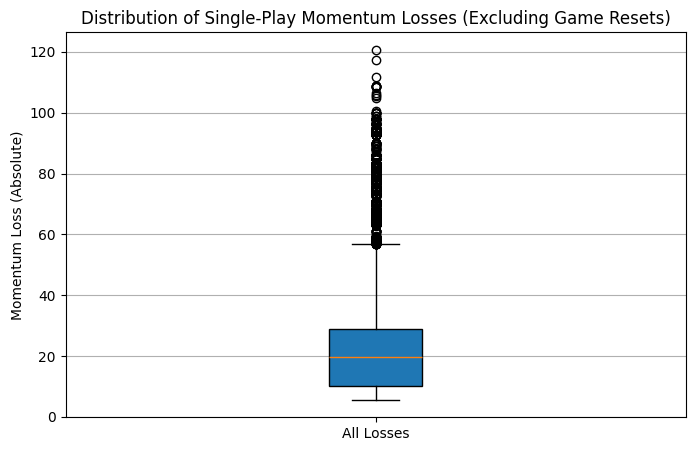

In [11]:
import matplotlib.pyplot as plt

# Calculate momentum changes
dfV5['game_id_shifted'] = dfV5['game_id'].shift(1)
dfV5['Home_Momentum_Change'] = dfV5['Home_Momentum_Score'].diff().fillna(0)
dfV5['Away_Momentum_Change'] = dfV5['Away_Momentum_Score'].diff().fillna(0)

# Remove momentum resets at the start of new games
dfV5.loc[dfV5['game_id'] != dfV5['game_id_shifted'], ['Home_Momentum_Change', 'Away_Momentum_Change']] = 0

# Combine all momentum losses into one list (for home and away)
momentum_losses = []

for col in ['Home_Momentum_Change', 'Away_Momentum_Change']:
    losses = dfV5[dfV5[col] < 0][col].abs()  # only consider losses, take absolute values
    momentum_losses.extend(losses)

# Create boxplot
plt.figure(figsize=(8, 5))
plt.boxplot(momentum_losses, vert=True, patch_artist=True)
plt.title("Distribution of Single-Play Momentum Losses (Excluding Game Resets)")
plt.ylabel("Momentum Loss (Absolute)")
plt.xticks([1], ['All Losses'])
plt.grid(axis='y')
plt.show()